In [80]:
import os

import random
import numpy as np
import seaborn as sn
import pandas as pd

import torch
import torch.nn as nn
from torch.autograd import Variable

from argparse import Namespace

import time

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from tqdm import notebook

import matplotlib.pyplot as plt

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
args = Namespace(
    dataset_dir = ".data",
    dataset_prefix = "faq_with_splits_",
    datasets = ["tokenized", "filtered", "lemmatized", "stemmed", "lemmatized_filtered", "stemmed_filtered"],
    model_save_dir = ".model_storage/MLP",
    model_state_file = "model",
    seed = 1234,
    num_epochs = 5,
    learning_rate = 1e-3,
    hidden_size = 100,
    batch_size = 128,
    cuda = True,
    train_column = 'short_question'
)

In [4]:
device = torch.device('cuda' if args.cuda & torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [5]:
args.model_state_file = os.path.join(args.model_save_dir, args.model_state_file)

In [6]:
if not os.path.exists(args.model_save_dir):
    os.makedirs(args.model_save_dir)
    print(f"Created directory {args.model_save_dir}")
else:
    print(f"{args.model_save_dir} directory already exists")

.model_storage/MLP directory already exists


## Loading datasets

In [7]:
faq_dataframes = {}

for dataset in args.datasets:
    df_path = os.path.join(args.dataset_dir, args.dataset_prefix + dataset + ".csv")
    print(f"Opening file: {df_path}")
    faq_dataframes[dataset] = pd.read_csv(df_path)

Opening file: .data\faq_with_splits_tokenized.csv
Opening file: .data\faq_with_splits_filtered.csv
Opening file: .data\faq_with_splits_lemmatized.csv
Opening file: .data\faq_with_splits_stemmed.csv
Opening file: .data\faq_with_splits_lemmatized_filtered.csv
Opening file: .data\faq_with_splits_stemmed_filtered.csv


In [8]:
faq_dataframes[args.datasets[0]].head()

,short_question,long_question,answer,main_category,sub_category,split
0,Hogy tudom a hamis bevésődéseket rossz gondola...,Hogy tudom a hamis bevésődéseket rossz gondola...,"Korlátozó hiedelmeknek hívják őket, de tudom, ...",Egészség,Mentális egészség,val
1,Milyen balhé volt Dancsó Péter és Fankadeli kö...,Milyen balhé volt Dancsó Péter és Fankadeli kö...,Röviden: Dancsó lehúzta Fankadeli egyik haverj...,Szórakozás,"Sztárok, bulvár",train
2,Hol vannak leírva a Semmiképp sem Dominion sza...,Hol vannak leírva a Semmiképp sem Dominion sza...,"A pontozás pont olyan, mint a dominionnál volt...",Szórakozás,Játékok,train
3,A legjobb fogorvos Magyarországon,A legjobb fogorvos Magyarországon Szóval tudni...,"Nincs olyan, hogy legjobb, a fogorvosok ugyanú...",Egészség,"Fogak, szájápolás",train
4,A hörcsögök egész szeme fekete vagy csak egy r...,A hörcsögök egész szeme fekete vagy csak egy r...,"Amúgy tényleg, szinte minden nap kiír valami f...",Állatok,Kisemlősök,train


## Seperate datasets by splits

In [9]:
def get_dataframes_for_split(split, datasets):
    return {ds: datasets[ds][datasets[ds].split == split] for ds in datasets}

In [10]:
train_dfs = get_dataframes_for_split('train', faq_dataframes)
test_dfs = get_dataframes_for_split('test', faq_dataframes)
valid_dfs = get_dataframes_for_split('val', faq_dataframes)

In [11]:
train_dfs[args.datasets[0]].head()

,short_question,long_question,answer,main_category,sub_category,split
1,Milyen balhé volt Dancsó Péter és Fankadeli kö...,Milyen balhé volt Dancsó Péter és Fankadeli kö...,Röviden: Dancsó lehúzta Fankadeli egyik haverj...,Szórakozás,"Sztárok, bulvár",train
2,Hol vannak leírva a Semmiképp sem Dominion sza...,Hol vannak leírva a Semmiképp sem Dominion sza...,"A pontozás pont olyan, mint a dominionnál volt...",Szórakozás,Játékok,train
3,A legjobb fogorvos Magyarországon,A legjobb fogorvos Magyarországon Szóval tudni...,"Nincs olyan, hogy legjobb, a fogorvosok ugyanú...",Egészség,"Fogak, szájápolás",train
4,A hörcsögök egész szeme fekete vagy csak egy r...,A hörcsögök egész szeme fekete vagy csak egy r...,"Amúgy tényleg, szinte minden nap kiír valami f...",Állatok,Kisemlősök,train
5,Mi történt a Sonic Boom al a Megamax on,Mi történt a Sonic Boom al a Megamax on Egy na...,Chara the FirstHuman nevű felhasználó válasza:...,Szórakozás,"Filmek, sorozatok",train


## Drop the unnecessary columns
Keeping the following columns:
- main category
- short question
- long question

In [12]:
def keep_columns(datasets, columns):
    return {ds: datasets[ds][columns] for ds in datasets}

In [13]:
columns = ['main_category', 'short_question', 'long_question']

train_dfs = keep_columns(train_dfs, columns)
test_dfs = keep_columns(test_dfs, columns)
valid_dfs = keep_columns(valid_dfs, columns)

In [14]:
train_dfs[args.datasets[0]].head()

,main_category,short_question,long_question
1,Szórakozás,Milyen balhé volt Dancsó Péter és Fankadeli kö...,Milyen balhé volt Dancsó Péter és Fankadeli kö...
2,Szórakozás,Hol vannak leírva a Semmiképp sem Dominion sza...,Hol vannak leírva a Semmiképp sem Dominion sza...
3,Egészség,A legjobb fogorvos Magyarországon,A legjobb fogorvos Magyarországon Szóval tudni...
4,Állatok,A hörcsögök egész szeme fekete vagy csak egy r...,A hörcsögök egész szeme fekete vagy csak egy r...
5,Szórakozás,Mi történt a Sonic Boom al a Megamax on,Mi történt a Sonic Boom al a Megamax on Egy na...


#### Get the main categories
Get main category names and assign ids for them

In [15]:
target_names = faq_dataframes[args.datasets[0]].main_category.unique().tolist()
target_dict = {k: v for v, k in enumerate(target_names)}

In [16]:
print(target_names)
print(target_dict)

['Egészség', 'Szórakozás', 'Állatok', 'Számítástechnika']
{'Egészség': 0, 'Szórakozás': 1, 'Állatok': 2, 'Számítástechnika': 3}


### Get vocabulary for bag of words

Which way of getting the vocabulary is faster? The primitive approach, iterating over the dataframe row by row, or the sigma male approach, which takes advantage of the library’s potential. This is a rhetorical question. It could be faster imo, but I'm pleased with this speed.

In [17]:
vocab = set()

start_time = int(time.time() * 1000)

for index, row in train_dfs[args.datasets[0]].iterrows():
    for word in row[args.train_column].lower().split():
        vocab.add(word)

end_time = int(time.time() * 1000)

print(f"Getting vocabulary primitively took {(end_time - start_time) / 1000.0} seconds")
print(f"Length of vocabulary is {len(vocab)}")

Getting vocabulary primitively took 7.686 seconds
Length of vocabulary is 115238


In [18]:
vocab = set()

start_time = int(time.time() * 1000)

train_dfs[args.datasets[0]].apply(lambda row: vocab.update(row[args.train_column].lower().split()), axis = 1)

end_time = int(time.time() * 1000)

print(f"Getting vocabulary in style took {(end_time - start_time) / 1000.0} seconds")
print(f"Length of vocabulary is {len(vocab)}")

Getting vocabulary in style took 2.267 seconds
Length of vocabulary is 115238


In [19]:
def get_vocabulary_for_each_dataset(dataframes):
    vocabularies = {}
    
    for dataframe in dataframes:
        start_time = int(time.time() * 1000)
        
        vocab = set()
        
        df = dataframes[dataframe]
        df.apply(lambda row: vocab.update(row[args.train_column].lower().split()), axis = 1)

        vocabularies[dataframe] = vocab
        
        end_time = int(time.time() * 1000)
        
        print(f"Getting vocabulary for '{dataframe}' dataset " \
                f"took {(end_time - start_time) / 1000.0} seconds, length = {len(vocab)}")

    return vocabularies

In [20]:
vocabularies = get_vocabulary_for_each_dataset(train_dfs)

Getting vocabulary for 'tokenized' dataset took 2.24 seconds, length = 115238
Getting vocabulary for 'filtered' dataset took 2.164 seconds, length = 115219
Getting vocabulary for 'lemmatized' dataset took 2.213 seconds, length = 79643
Getting vocabulary for 'stemmed' dataset took 2.228 seconds, length = 140792
Getting vocabulary for 'lemmatized_filtered' dataset took 2.091 seconds, length = 73616
Getting vocabulary for 'stemmed_filtered' dataset took 2.052 seconds, length = 68621


In [21]:
word = list(vocabularies[args.datasets[0]])[4]
word

'haveromat'

#### Getting the index for a word

In [22]:
def create_index_of_word(vocabularies):
    index_of_word = {}
    for dataset_key in vocabularies:
        index_of_word[dataset_key] = {value: key for key, value in enumerate(vocabularies[dataset_key])}
    return index_of_word

In [23]:
index_of_word = create_index_of_word(vocabularies)

In [24]:
idx = index_of_word[args.datasets[0]][word]
idx

4

### Get a batch of sentences

In [58]:
def bow_rep(question, input_size, index_of_word):
    layer = np.zeros(input_size, dtype=float)
    words = question.lower().split()
    
    for word in words:
        word = word.lower()
        if word in index_of_word:
            layer[index_of_word[word]] += 1
    return layer

In [65]:
def get_batch(df, i, batch_size, input_size, index_of_word):  
    batch = df[i * batch_size : (i + 1) * batch_size]
    batch_q = batch[args.train_column].apply(lambda x: bow_rep(x, input_size, index_of_word))
    targets_df = batch.main_category.apply(lambda x: target_dict[x])
     
    return np.array(batch_q.tolist()), np.array(targets_df.tolist())

## Multilayer Perceptron

In [66]:
class MLP(nn.Module):
     def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.layer_1 = nn.Linear(input_size, hidden_size, bias=True)
        self.relu = nn.ReLU()
        self.layer_2 = nn.Linear(hidden_size, hidden_size, bias=True)
        self.output_layer = nn.Linear(hidden_size, num_classes, bias=True)
 
     def forward(self, x):
        out = self.layer_1(x)
        out = self.relu(out)
        out = self.layer_2(out)
        out = self.relu(out)
        out = self.output_layer(out)
        return out

In [67]:
def class_accuracy(prediction, actual):
    rounded_predictions = prediction.argmax(1)
    correct = (rounded_predictions == actual).float()

    acc = correct.sum() / len(correct)
    return acc

In [68]:
def train_model(model, train_dataframe, vocabulary, index_of_word, optimizer, criterion, bar):

    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    total_batch = len(train_dataframe) // args.batch_size

    for i in range(total_batch):
        batch_input, batch_target = get_batch(train_dataframe, i, args.batch_size, len(vocabulary), index_of_word)
        
        batch_input = Variable(torch.FloatTensor(batch_input))
        batch_target = Variable(torch.LongTensor(batch_target))

        optimizer.zero_grad()
        
        predictions = model(batch_input)
        loss = criterion(predictions, batch_target)
        acc = class_accuracy(predictions, batch_target)

        loss.backward()

        optimizer.step()
    
        epoch_loss += loss.item()
        epoch_acc += acc.item()

        bar.set_postfix(loss=(epoch_loss / (i + 1)), acc=(epoch_acc / (i + 1)))
        bar.update()

    return epoch_loss / total_batch, epoch_acc / total_batch

In [69]:
def evaluate_model(model, dataframe, vocabulary, index_of_word, optimizer, criterion, bar):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()

    total_predicted = []

    total_batch = len(dataframe) // args.batch_size
    
    with torch.no_grad():
        for i in range(total_batch):
            batch_input, batch_target = get_batch(dataframe, i, args.batch_size, len(vocabulary), index_of_word)
            
            batch_input = Variable(torch.FloatTensor(batch_input))
            batch_target = Variable(torch.LongTensor(batch_target))
            
            predictions = model(batch_input)
            loss = criterion(predictions, batch_target)
            acc = class_accuracy(predictions, batch_target)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

            _, predicted = torch.max(predictions.data, 1)
            total_predicted += predicted.tolist()
            
            bar.set_postfix(loss=epoch_loss / (i + 1), acc=epoch_acc / (i + 1))
            bar.update()
            
    return epoch_loss / total_batch, epoch_acc / total_batch, total_predicted

In [70]:
train_losses = {}
train_accuracies = {}

valid_losses = {}
valid_accuracies = {}

for dataset_key in args.datasets:
    start_time = int(time.time() * 1000)
    
    best_valid_loss = float('inf')

    train_losses[dataset_key] = []
    train_accuracies[dataset_key] = []

    valid_losses[dataset_key] = []
    valid_accuracies[dataset_key] = []
    
    train_df = train_dfs[dataset_key]
    valid_df = valid_dfs[dataset_key]
    vocabulary = vocabularies[dataset_key]
    index_of_word_ = index_of_word[dataset_key]

    model = MLP(len(vocabulary), args.hidden_size, len(target_names))
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()  
    criterion = criterion.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr = args.learning_rate)
    
    train_size = train_df.shape[0] // args.batch_size
    valid_size = valid_df.shape[0] // args.batch_size
    
    epoch_bar = notebook.tqdm(desc=f"'{dataset_key}' epoch", total=args.num_epochs, position=0, leave=False)
    train_bar = notebook.tqdm(desc=f"'{dataset_key}' train", total=train_size, position=1, leave=False)
    valid_bar = notebook.tqdm(desc=f"'{dataset_key}' valid",total=valid_size, position=1, leave=False)
    
    for epoch in range(args.num_epochs):
        train_bar.n = 1
        valid_bar.n = 1

        train_bar.refresh()
        valid_bar.refresh()

        train_loss, train_acc = train_model(model, train_df, vocabulary, index_of_word_, optimizer, criterion, train_bar)
        valid_loss, valid_acc, _ = evaluate_model(model, valid_df, vocabulary, index_of_word_, optimizer, criterion, valid_bar)
    
        train_losses[dataset_key].append(train_loss)
        train_accuracies[dataset_key].append(train_acc)

        valid_losses[dataset_key].append(valid_loss)
        valid_accuracies[dataset_key].append(valid_acc)
    
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), args.model_state_file + "_" + dataset_key + ".pth")

        epoch_bar.update()
        epoch_bar.refresh()
    end_time = int(time.time() * 1000)

    print(f"Training took {(end_time - start_time) / 1000.0} seconds for '{dataset_key}' dataset, " \
        f"device = '{device}', epochs = {args.num_epochs}")

'tokenized' epoch:   0%|          | 0/5 [00:00<?, ?it/s]

'tokenized' train:   0%|          | 0/839 [00:00<?, ?it/s]

'tokenized' valid:   0%|          | 0/179 [00:00<?, ?it/s]

Training took 1551.103 seconds for 'tokenized' dataset, device = 'cpu', epochs = 5


'filtered' epoch:   0%|          | 0/5 [00:00<?, ?it/s]

'filtered' train:   0%|          | 0/839 [00:00<?, ?it/s]

'filtered' valid:   0%|          | 0/179 [00:00<?, ?it/s]

Training took 1577.377 seconds for 'filtered' dataset, device = 'cpu', epochs = 5


'lemmatized' epoch:   0%|          | 0/5 [00:00<?, ?it/s]

'lemmatized' train:   0%|          | 0/839 [00:00<?, ?it/s]

'lemmatized' valid:   0%|          | 0/179 [00:00<?, ?it/s]

Training took 1011.985 seconds for 'lemmatized' dataset, device = 'cpu', epochs = 5


'stemmed' epoch:   0%|          | 0/5 [00:00<?, ?it/s]

'stemmed' train:   0%|          | 0/839 [00:00<?, ?it/s]

'stemmed' valid:   0%|          | 0/179 [00:00<?, ?it/s]

Training took 2043.709 seconds for 'stemmed' dataset, device = 'cpu', epochs = 5


'lemmatized_filtered' epoch:   0%|          | 0/5 [00:00<?, ?it/s]

'lemmatized_filtered' train:   0%|          | 0/839 [00:00<?, ?it/s]

'lemmatized_filtered' valid:   0%|          | 0/179 [00:00<?, ?it/s]

Training took 984.713 seconds for 'lemmatized_filtered' dataset, device = 'cpu', epochs = 5


'stemmed_filtered' epoch:   0%|          | 0/5 [00:00<?, ?it/s]

'stemmed_filtered' train:   0%|          | 0/839 [00:00<?, ?it/s]

'stemmed_filtered' valid:   0%|          | 0/179 [00:00<?, ?it/s]

Training took 872.228 seconds for 'stemmed_filtered' dataset, device = 'cpu', epochs = 5


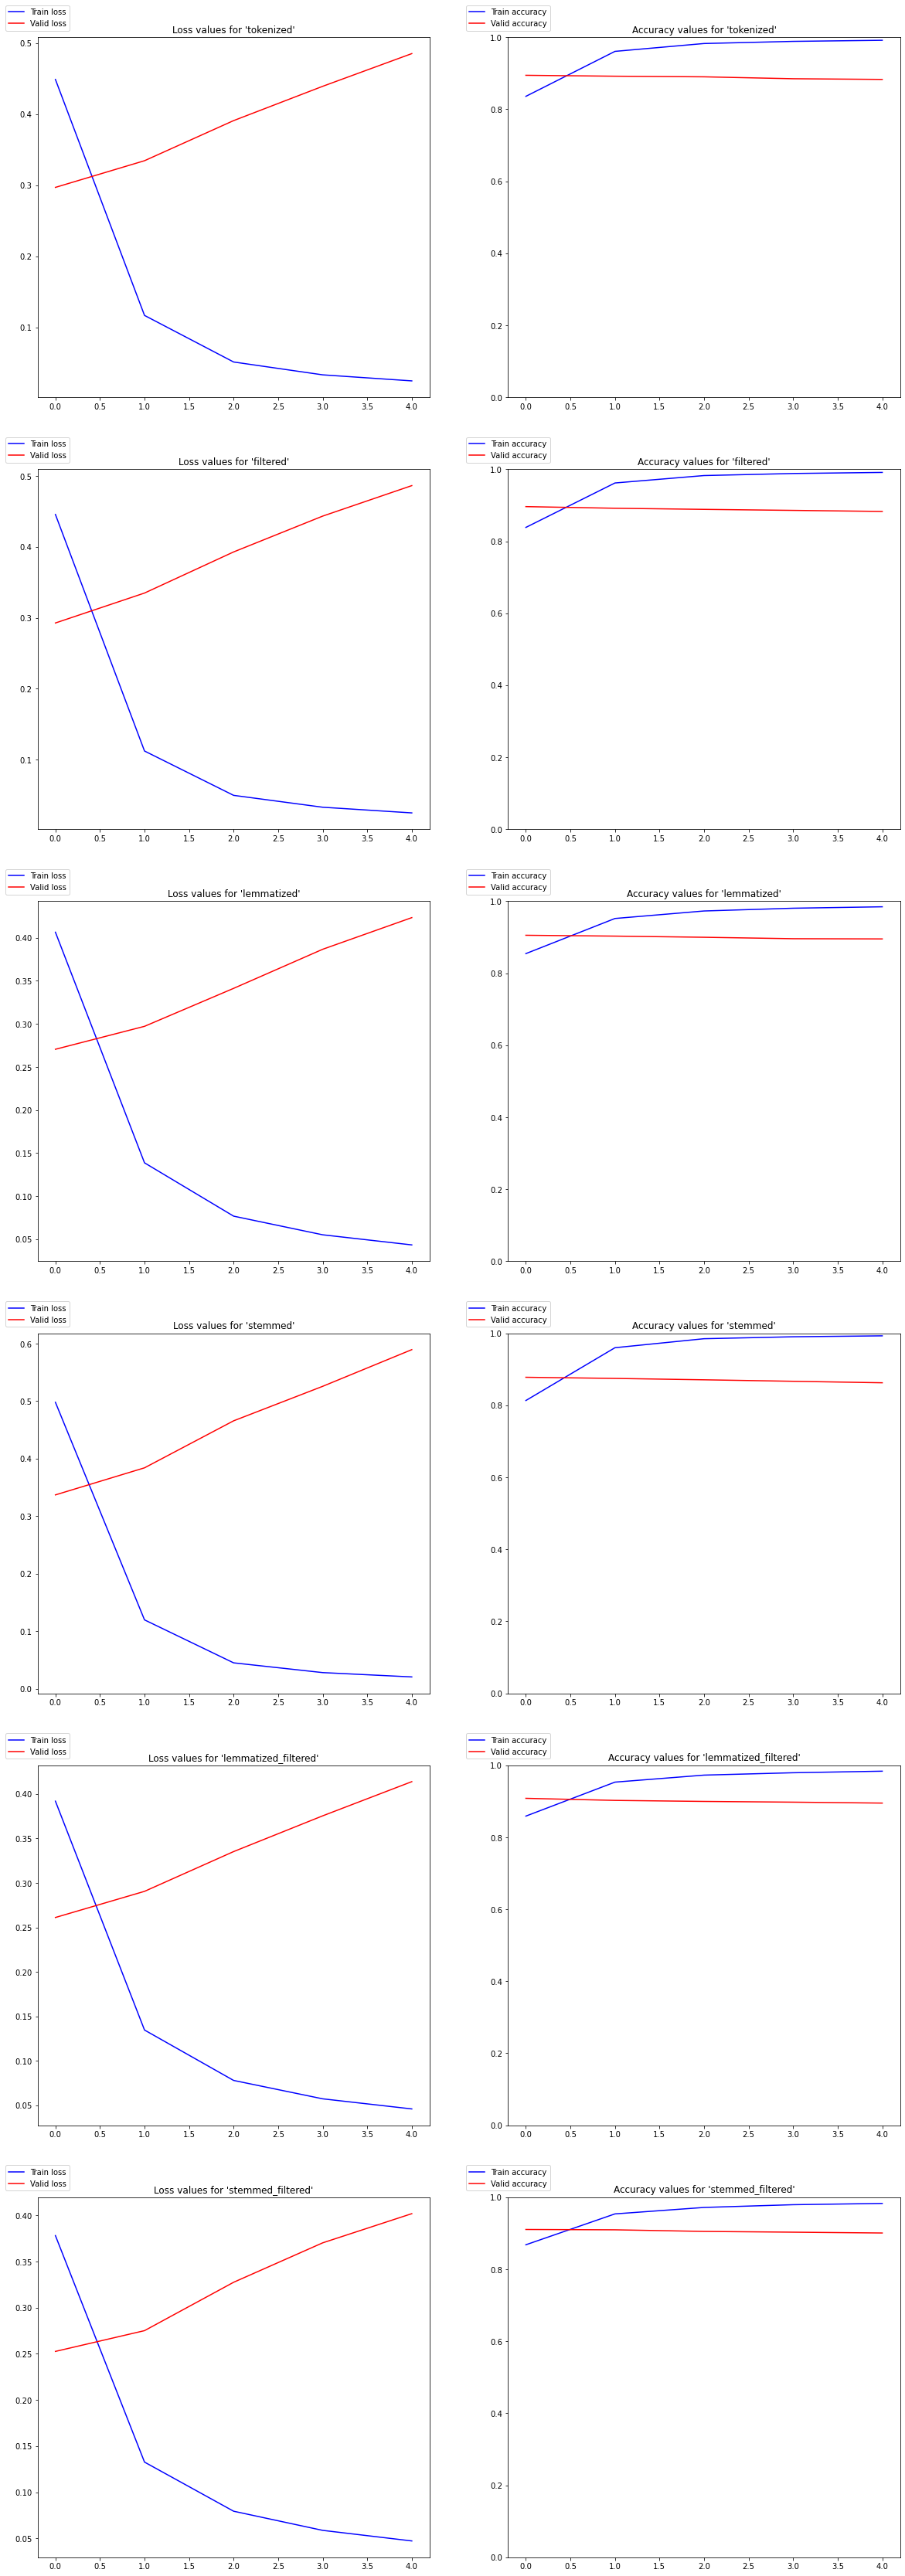

In [71]:
fig, axs = plt.subplots(len(args.datasets), 2, figsize=(10 * 2, 10 * len(args.datasets)))

for idx, dataset in enumerate(args.datasets):
    axs[idx, 0].set_title(f"Loss values for '{dataset}'")
    axs[idx, 0].plot([*range(args.num_epochs)], train_losses[dataset], color = 'b', label='Train loss')
    axs[idx, 0].plot([*range(args.num_epochs)], valid_losses[dataset], color = 'r', label='Valid loss')
    axs[idx, 0].legend(loc="upper center", bbox_to_anchor=(0.0, 1.1), ncol=1)
    
    axs[idx, 1].set_title(f"Accuracy values for '{dataset}'")
    axs[idx, 1].axis(ymin = 0, ymax = 1)
    axs[idx, 1].plot([*range(args.num_epochs)], train_accuracies[dataset], color = 'b', label='Train accuracy')
    axs[idx, 1].plot([*range(args.num_epochs)], valid_accuracies[dataset], color = 'r', label='Valid accuracy')
    axs[idx, 1].legend(loc="upper center", bbox_to_anchor=(0.0, 1.1), ncol=1)
    
plt.show()

In [72]:
predictions = {}
number_of_batches = 0

for dataset_key in args.datasets:
    test_df = test_dfs[dataset_key]
   
    vocabulary = vocabularies[dataset_key]
    index_of_word_ = index_of_word[dataset_key]
    
    test_size = test_df.shape[0] // args.batch_size
    test_bar = notebook.tqdm(desc=f"'{dataset_key}' test", total=test_size, position=1, leave=False)

    model = MLP(len(vocabulary), args.hidden_size, len(target_names))
    model.load_state_dict(torch.load(args.model_state_file + "_" + dataset_key + ".pth"))
    _, _, predictions[dataset_key] = evaluate_model(model, test_df, vocabulary, index_of_word_, optimizer, criterion, test_bar)

'tokenized' test:   0%|          | 0/179 [00:00<?, ?it/s]

'filtered' test:   0%|          | 0/179 [00:00<?, ?it/s]

'lemmatized' test:   0%|          | 0/179 [00:00<?, ?it/s]

'stemmed' test:   0%|          | 0/179 [00:00<?, ?it/s]

'lemmatized_filtered' test:   0%|          | 0/179 [00:00<?, ?it/s]

'stemmed_filtered' test:   0%|          | 0/179 [00:00<?, ?it/s]

In [73]:
test_target = test_dfs[args.datasets[0]].main_category.apply(lambda x: target_dict[x]).tolist()

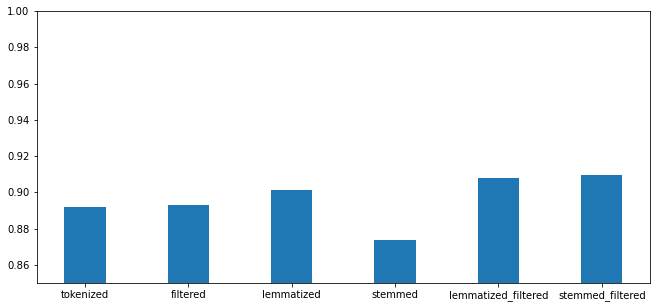

In [98]:
fig, ax = plt.subplots(1, 1, figsize=(11, 5))
accuracy_scores = []

for dataset in args.datasets:
    pred = predictions[dataset]
    accuracy_scores.append(accuracy_score(test_target[:len(pred)], pred))
ax.axis(ymin = 0.85, ymax = 1)
ax.bar(args.datasets, accuracy_scores, width=0.4)

plt.show()

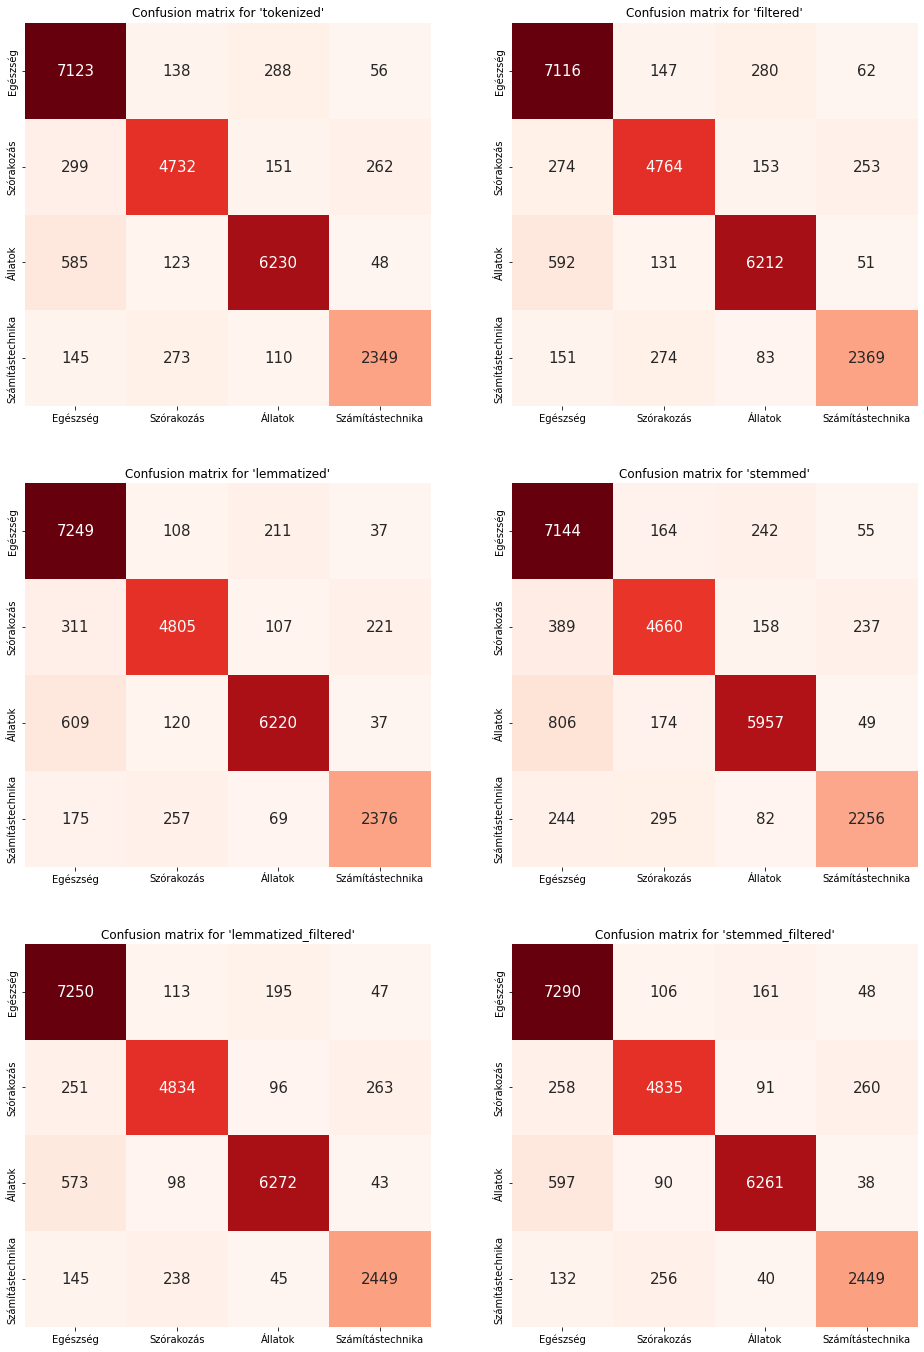

In [78]:
fig, axs = plt.subplots(len(args.datasets) // 2, 2, figsize=(16, 4 * len(args.datasets)))

for idx, dataset_key in enumerate(args.datasets):
    axs[idx // 2][idx % 2].set_title(f"Confusion matrix for '{dataset_key}'")
    
    pred = predictions[dataset_key]
    
    cm = confusion_matrix(test_target[:len(pred)], pred)
    cm_df = pd.DataFrame(cm, index=target_names, columns=target_names)
    
    heatmap = sn.heatmap(cm_df, annot=True, ax=axs[idx // 2][idx % 2], cmap='Reds', fmt='g', annot_kws={"size": 15}, cbar=False)

plt.show()

In [99]:
for dataset_key in args.datasets:
    pred = predictions[dataset_key]
    report = classification_report(test_target[:len(pred)], pred, target_names=target_names)
    print(f"Classification report for '{dataset_key}':\n{report}\n{'=' * 60}")

Classification report for 'tokenized':
                  precision    recall  f1-score   support

        Egészség       0.87      0.94      0.90      7605
      Szórakozás       0.90      0.87      0.88      5444
         Állatok       0.92      0.89      0.91      6986
Számítástechnika       0.87      0.82      0.84      2877

        accuracy                           0.89     22912
       macro avg       0.89      0.88      0.88     22912
    weighted avg       0.89      0.89      0.89     22912

Classification report for 'filtered':
                  precision    recall  f1-score   support

        Egészség       0.87      0.94      0.90      7605
      Szórakozás       0.90      0.88      0.89      5444
         Állatok       0.92      0.89      0.91      6986
Számítástechnika       0.87      0.82      0.84      2877

        accuracy                           0.89     22912
       macro avg       0.89      0.88      0.89     22912
    weighted avg       0.89      0.89      0.89 